In [27]:
# Import all necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain


In [5]:
# Load the MNIST dataset.

mnist_data = fetch_openml('mnist_784', as_frame=False)
X, y = mnist_data.data, mnist_data.target
X.shape
y.shape

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000,)

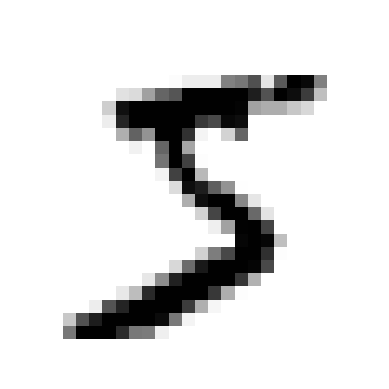

In [35]:
# Take a peek of one image from the dataset.

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
# Check the target label for this digit.

y[0]

'5'

In [6]:
# Create training and test sets. The fetch_openml dataset is already shuffled, so all cross validation folds
# will be similar.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# Training a binary classifier (5 and not 5, two classes)

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [14]:
# Measuring accuracy of SGD Classifier using K-fold cross validation.

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# Now using a dummy classifier.

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [16]:
# Measuring accuracy of the dummy classifier.

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [18]:
# Performing stratified K-fold cross validation. Should yield the same result as using sklearn's built-in CV.

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
# Performs K-fold CV but instead returns actual predictions instead of evaluation scores.

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [22]:
# Making confusion matrix.

cm_binclf = confusion_matrix(y_train_5, y_train_pred)
cm_binclf

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
# Example of perfect classification from confusion matrix.

y_train_perfect_predictions = y_train_5
cm_binclf_perf = confusion_matrix(y_train_5, y_train_perfect_predictions)
cm_binclf_perf

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [26]:
# Sklearn method of calculating precision and recall.

print(precision_score(y_train_5, y_train_pred)) # 3530 / (687+3530)
print(recall_score(y_train_5, y_train_pred)) # 3530 / (1891+3530)

0.8370879772350012
0.6511713705958311


In [27]:
# F1 score is the harmonic mean of precision and recall, so more weight is given to lower values.
# F1 = TP / (TP + ((FN+FP)/2))

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [30]:
# You can set the prediction threshold manually using decision_function().

y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)

# SGD classifier uses a threshold of 0, raising this threshold decreases the recall and results
# in a misclassification in this case.

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
# Use cross_val_predict to determine the appropriate threshold.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

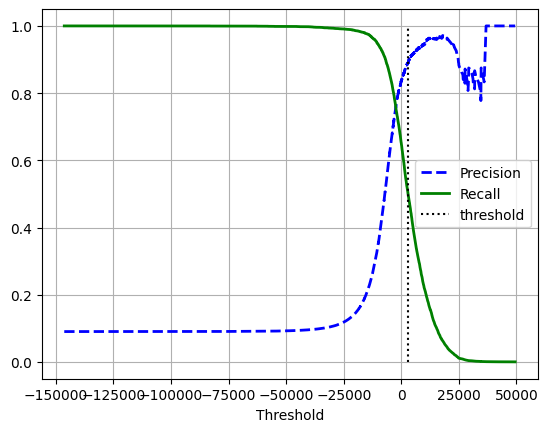

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.xlabel("Threshold")
plt.legend()
plt.grid()
plt.show()

In [34]:
# if you want a precision of 90%, you can use the argmax() function to find the lowest threshold that
# gives you a precision of 0.90.

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [36]:
# Now we make predictions using the new threshold.

y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
print(recall_at_90_precision)

0.9000345901072293
0.4799852425751706


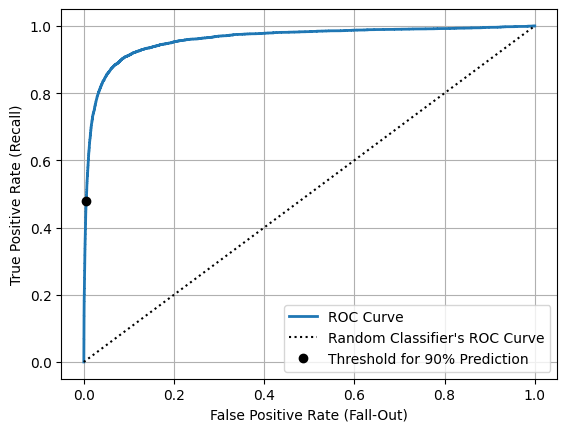

In [40]:
# ROC Curve that plots the true positive rate against the false positive rate.

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random Classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% Prediction")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.grid()
plt.show()

In [42]:
# We now compare Area Under Curve (AUC) to compare classifiers.

print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


In [44]:
# Creating a Random Forest Classifier to compare and contrast against the SGD Classifier.

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

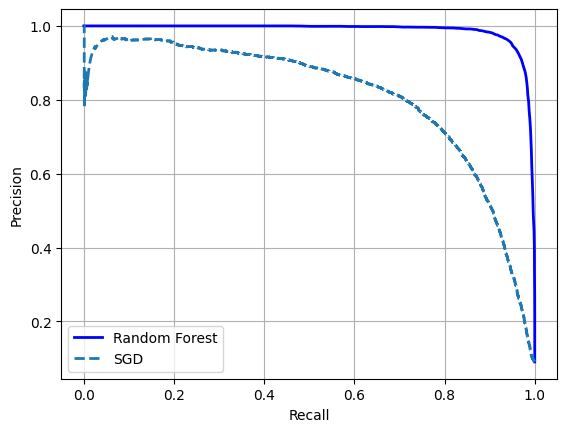

In [45]:
# Passing estimated probabilities to the precision_recall_curve() function.

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

In [48]:
# Check F1 Score and ROC_AUC Score to validate that the Random Forest Classifier performs much better
# than the SGD classifier.

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145


In [50]:
# We now construct a Support Vector Machine Classifier for classification.

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [52]:
# See the scores by using decision_function().

some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores.round(2))
print(some_digit_scores.argmax())

[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
5


In [57]:
# We now construct a One vs Rest Classifier.

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

# Now we make a prediction.

print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

['5']
10


In [11]:
# Now we implement an SGD Classifier for Multiclass Classification

sgd_multiclass = SGDClassifier(random_state=42)
sgd_multiclass.fit(X_train, y_train)
sgd_multiclass.predict([some_digit])

array(['3'], dtype='<U1')

In [13]:
# An incorrect prediction was made by the SGD Classifier, it used the One vs Rest Strategy under the hood.
# Check the decision_function() to look each class score.

sgd_multiclass.decision_function([some_digit]).round(2)

# Observation: Scores are mostly negative so the classifier is not confident in the predictions made.

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [14]:
# To further this observation, we now check the cross validation score.

cross_val_score(sgd_multiclass, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [16]:
# We can increase the cross validation scores of the SGD Classifier by standardizing the data.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_multiclass, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

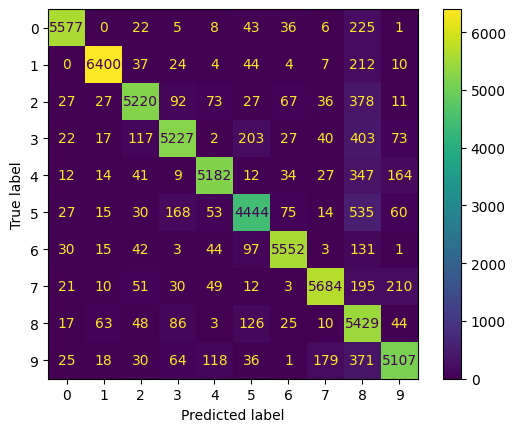

In [19]:
# We create a colored Confusion matrix for error analysis visualization.

y_train_pred = cross_val_predict(sgd_multiclass, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

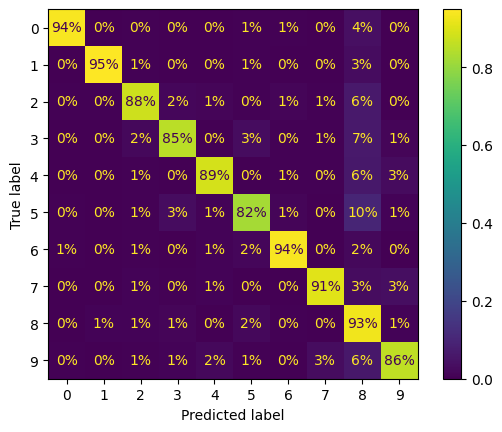

In [21]:
# Confusion Matrix but in percents.

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

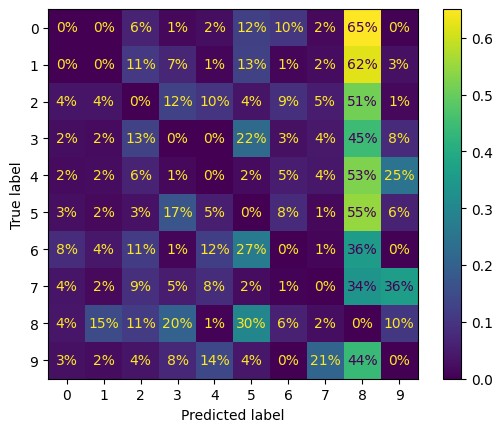

In [22]:
# Errors normalized by row.

sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true",
                                        values_format=".0%")

In [25]:
# Multilabel Classification

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [26]:
# Computing the F1 score for the multilabel K Neighbors Classifier.

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9774922346896824

In [28]:
# We now construct a Chain Classifier.

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

chain_clf.predict([some_digit])

array([[0., 1.]])

In [30]:
# We now perform noise removal from the image data.

np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

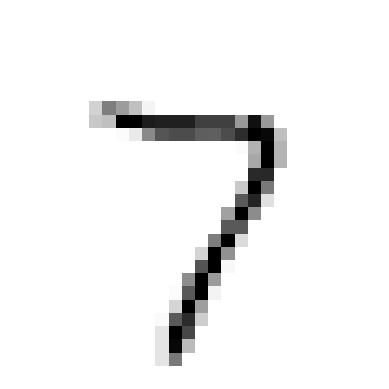

In [33]:
# Our final classification task is to perform multioutput-multiclass classification.

knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()